In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv("file.csv")
data.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [3]:
data = data.drop(columns="Unnamed: 0")

In [4]:
data["labels"] = data['labels'].map({'bad': 0, 'good': 1, 'neutral': 0.5})


In [5]:
data.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,0.5
1,"Try talking with ChatGPT, our new AI system wh...",1.0
2,ChatGPT: Optimizing Language Models for Dialog...,0.5
3,"THRILLED to share that ChatGPT, our new model ...",1.0
4,"As of 2 minutes ago, @OpenAI released their ne...",0.0


In [6]:
data.shape

(101101, 2)

<Axes: xlabel='labels', ylabel='count'>

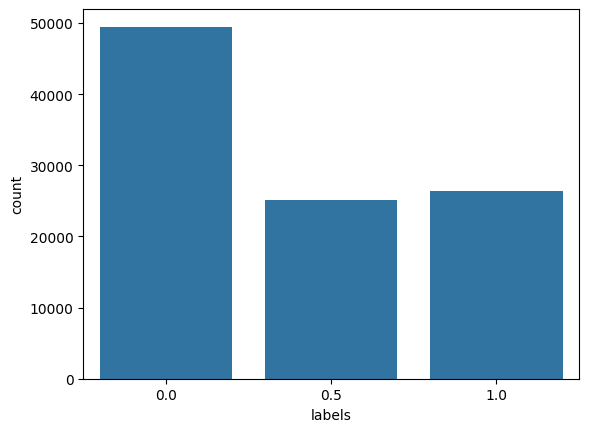

In [7]:
sns.countplot(x='labels', data = data)

In [8]:
positive_tweets = data[data['labels'] == 1.0]['tweets']
neutral_tweets = data[data["labels"] == 0.5]["tweets"]
negative_tweets = data[data["labels"] == 0]["tweets"]
negative_tweets

4         As of 2 minutes ago, @OpenAI released their ne...
6         As of 2 minutes ago, @OpenAI released their ne...
10        GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...
17        #ai Models are set to become the search engine...
39        Google is done.\n\nCompare the quality of thes...
                                ...                        
101087    How can anybody focus on doing anything else n...
101088    Our world is about to get really messed up aga...
101091    There’s a collective awe that continues to ema...
101095    ChatGPT remains undefeated https://t.co/7BzTyW...
101097    Can’t wait for Boston Dynamics to integrate Ch...
Name: tweets, Length: 49488, dtype: object

In [9]:
count_positive_labels = (data["labels"] == 1).sum()
count_negative_labels = (data["labels"] == 0).sum()
count_neutral_labels = (data["labels"] == 0.5).sum()

print("Number of positive labels: ", count_positive_labels)
print("Number of negative labels: ", count_negative_labels)
print("Number of neutral labels: ", count_neutral_labels)


Number of positive labels:  26421
Number of negative labels:  49488
Number of neutral labels:  25192


In [10]:
positive_indices = np.where(data["labels"] == 1)[0]
negative_indices = np.where(data["labels"] == 0)[0]
neutral_indices = np.where(data["labels"] == 0.5)[0]

train_pos = positive_indices[:int(0.8 * len(positive_indices))]
test_pos = positive_indices[int(0.8 * len(positive_indices)):]

train_neg = negative_indices[:int(0.8 * len(negative_indices))]
test_neg = negative_indices[int(0.8 * len(negative_indices)):]

train_neutral = neutral_indices[:int(0.8 * len(neutral_indices))]
test_neutral = neutral_indices[int(0.8 * len(neutral_indices)):]


train_pos = data.iloc[train_pos , 0]
test_pos = data.iloc[test_pos , 0]

train_neg = data.iloc[train_neg , 0]
test_neg = data.iloc[test_neg , 0]

train_neutral = data.iloc[train_neutral , 0]
test_neutral = data.iloc[test_neutral , 0]


train_x = pd.concat([train_pos, train_neutral, train_neg]).reset_index(drop=True)
test_x = pd.concat([test_pos, test_neutral, test_neg]).reset_index(drop=True)

print("Train set shape:", train_x.shape)
print("Test set shape:", test_x.shape)


Train set shape: (80879,)
Test set shape: (20222,)


In [11]:
train_y = np.concatenate([np.ones((len(train_pos), 1)), 0.5 * np.ones((len(train_neutral), 1)), np.zeros((len(train_neg), 1))])
test_y = np.concatenate([np.ones((len(test_pos), 1)), 0.5 * np.ones((len(test_neutral), 1)), np.zeros((len(test_neg), 1))])

In [12]:
print("train_x.shape = " + str(train_x.shape)) 
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_x.shape = (80879,)
train_y.shape = (80879, 1)
test_y.shape = (20222, 1)


In [13]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def process_tweet(tweet):
    tweet = tweet.lower()
    # Remove URLS
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)
    # Remove special characters and numbers
    tweet = re.sub(r'\W', ' ', tweet)
    # Remove single characters
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    # Remove single characters at the beginning
    tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', tweet)
    words = word_tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words if word not in stop_words]
    return words


data['transformed_text'] = data['tweets'].apply(process_tweet)



In [14]:
data.head()

,tweets,labels,transformed_text
0,ChatGPT: Optimizing Language Models for Dialog...,0.5,"[chatgpt, optim, languag, model, dialogu, openai]"
1,"Try talking with ChatGPT, our new AI system wh...",1.0,"[tri, talk, chatgpt, new, ai, system, optim, d..."
2,ChatGPT: Optimizing Language Models for Dialog...,0.5,"[chatgpt, optim, languag, model, dialogu, ai, ..."
3,"THRILLED to share that ChatGPT, our new model ...",1.0,"[thrill, share, chatgpt, new, model, optim, di..."
4,"As of 2 minutes ago, @OpenAI released their ne...",0.0,"[2, minut, ago, openai, releas, new, chatgpt, ..."


In [15]:
def build_freqs(tweets, labels):
    freqs = {}
    for tweet, label in zip(tweets, labels):
        words = process_tweet(tweet)
        for word in words:
            pair = (word, float(label))
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

freqs = build_freqs(train_x , train_y)
print("type(freqs) =", type(freqs))
print("len(freqs) =", len(freqs.keys()))


C:\Users\dell\AppData\Local\Temp\ipykernel_14000\4031954575.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pair = (word, float(label))


type(freqs) = <class 'dict'>
len(freqs) = 61843


In [16]:
from wordcloud import WordCloud  
wc = WordCloud(width=200,height=200,min_font_size=10,background_color='white')


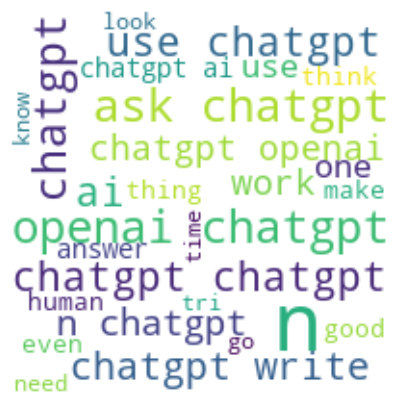

In [17]:
wordcloud = wc.generate(" ".join(data['transformed_text'].explode().astype(str).fillna('')))
plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
def sigmoid(z): 
    h = 1/(1+np.exp(-z))    
    return h

In [55]:
def gradientDescent(x, y, theta, alpha, num_iters):
    m = x.shape[0]
    lambda_ = 0.01

    for i in range(num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)
        J = (-1/m) * (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h))) + (lambda_/(2*m)) * np.sum(np.square(theta[1:]))
        
        gradient = (1/m) * np.dot(x.T, (h-y))
        theta[0] = theta[0] - alpha * gradient[0]
        theta[1:] = theta[1:] - alpha * (gradient[1:] + (lambda_/m) * theta[1:])
        

    return float(J), theta

In [99]:
def extract_features(tweet, freqs, process_tweet=process_tweet):
    word_l = process_tweet(tweet)
    
    x = np.zeros(4) 
    
    # bias term is set to 1
    x[0] = 1
    for word in word_l:
        x[1] += freqs.get((word,1.0),0)   # positive
        x[2] += freqs.get((word,0.5),0)   # neutral
        x[3] += freqs.get((word,0.0),0)   # negative
        
    x = x[None, :]  
    return x

In [96]:
X = np.zeros((len(train_x), 4))
for i in range(len(train_x)):
    tweet = train_x.iloc[i]
    X[i, :]= extract_features(tweet,freqs)

Y = train_y
J, theta = gradientDescent(X, Y, np.zeros((4, 1)), 1e-9, 1500)

print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.57866763.
The resulting vector of weights is [-7e-08, 0.00038215, 6.208e-05, -0.00027216]


C:\Users\dell\AppData\Local\Temp\ipykernel_14000\3785445137.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(J), theta


In [100]:
# UNQ_C4 GRADED FUNCTION: predict_tweet
def predict_tweet(tweet, freqs, theta):
    
    x = extract_features(tweet,freqs)
    y_pred = sigmoid(np.dot(x,theta))
    
    
    return y_pred

In [101]:
# Run this cell to test your function
for tweet in ['good','I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))    
    

good -> 0.660568
I am happy -> 0.516120
I am bad -> 0.481331
this movie should have been great. -> 0.605457
great -> 0.606050
great great -> 0.702969
great great great -> 0.784522
great great great great -> 0.848509


C:\Users\dell\AppData\Local\Temp\ipykernel_14000\1326845478.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))


In [102]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    y_hat = []
    
    for tweet in test_x:
        y_pred = predict_tweet(tweet, freqs , theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        elif y_pred == 0.5:
            # append 0 to the list
            y_hat.append(0.5)
        else:
            y_hat.append(0.0)

    accuracy = (y_hat==np.squeeze(test_y)).sum()/len(test_x)

    
    return accuracy

In [103]:
my_tweet = data["tweets"].iloc[63]
print(my_tweet)
print(data["labels"].iloc[63])
process_tweet(my_tweet)
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.59:
    print('Positive sentiment')
elif y_hat == 0.5 : 
    print('Neutral sentiment')
else:
    print("Negative sentiment")

ChatGPT, so far, feels like it's very good at extractive Q&amp;A, not so much at dialogue.
1.0
[[0.82838018]]
Positive sentiment


In [104]:
my_tweet = "Chat gpt is bad!"
process_tweet(my_tweet)
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
elif y_hat == 0.5 : 
    print('Neutral sentiment')
else:
    print("Negative sentiment")

[[0.49883888]]
Negative sentiment
